This file includes the code of CyberShapley as described in section 3 with evaluation example 

In [1]:
from tqdm import tqdm
from torch.nn.functional import softmax, cross_entropy
import networkx as nx
import pickle
from scipy.special import binom
import itertools
import copy
import shap
from shap._explanation import Explanation
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from anomaly_detector_architecture import ad_model

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

This data includes the events that flagged as suspicious and splitted to train/var/test- as described in section 4.2 
The splitting of data is occurred in - 'Make sequence dataset.ipynb'

In [2]:
#choose dataset by name
ds_name = "PublicArena" #Cadets, Theia, PublicArena

In [3]:
data_folder = f"dataset/{ds_name.lower()}/"
events_df = pd.read_csv(data_folder+f"{ds_name}_Krystal_transformation.csv")
seq_len = 10 # set seq len
threshold_anomaly_score = 0.5

In [4]:
set_name = "test" #train, val, test

fname_data_for_model = f"{ds_name}_{set_name}_data_for_model.pkl"
fname_data_for_graph = f"{ds_name}_{set_name}_data_for_graph.pkl"

test_data_for_model = pickle.load(open(data_folder+fname_data_for_model, "rb" ) )
test_data_for_graph = pickle.load(open(data_folder+fname_data_for_graph, "rb" ) )

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load anomaly detection model

In [6]:
options = dict()
options['input_size'] =  41 #len(train_logs[0][0])
options['hidden_size'] = 128
options['num_layers'] = 2
options['num_classes'] = 6
options['batch_size'] = 64
options['p_dropout'] = 0.3
options['bidirectional'] = False
options['seq_len'] = 10

In [7]:
model = ad_model(input_size=options['input_size'],
                 hidden_size=options['hidden_size'],
                 num_layers=options['num_layers'],
                 num_classes=options['num_classes'],
               p_dropout=options['p_dropout'],
               bidirectional=options['bidirectional'])
model

ad_model(
  (lstm): LSTM(41, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [8]:
# fill model with the trained weights

if ds_name == "PublicArena":
    model_path = "anomaly_detection_model_publicArena.pth"
else: #ds_name == Cadets, Theia
    model_path = "anomaly_detection_model.pth"
model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [9]:
model.eval()

ad_model(
  (lstm): LSTM(41, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

# XAI:

## Code for feature importance

In [10]:
def reverse_transform(sequence, masked_graph):
    """
    get the masked sequence - after reducing the non coalition events
    :param sequence: sequence in original space representation.
    :param events_to_keep: which of the events we want to keep for this sequence.
    :param transform_dict:
    :return: masked sequence in original space representation
    """
    empty_event = np.zeros_like(sequence[0])
    events_to_keep = []
    for group_ls_events in masked_graph:
        events_to_keep += group_ls_events
    # masked_sequence = [event if ind in events_to_keep else empty_event for ind, event in enumerate(sequence)]
    masked_sequence = [event for ind, event in enumerate(sequence) if ind in events_to_keep]
    # masked_sequence += [empty_event for _ in range(len(masked_sequence), len(sequence))] #padd with zeros
    return masked_sequence


def sample_all_combinations(sequence, graph_ls, num_connected_comp, explain_subgraphs=True):
    """
    This method sample all the possible combinations (= 2^features amount-2) of 'sample'
    and return the combinations
    params:
    :param graph_ls: sample in latent representation. - list of subgraphs - each subgraph represented as list of events indices due to the time stamp
    :param sequence - explained sequence
    :param num_connected_comp - number of connected components (subgraphs)
    :param explain_subgraphs - explain the subgraphs - if we want to explain the events we need to change - "num_connected_comp"
    """
    samples_amount = 2 ** num_connected_comp - 2 + 1

    combination_samples = np.empty(shape=(samples_amount, 3), dtype=object) #1 col for the coalition binary struction (1,0,1,1..) and 1 col for the matching sample in original space

    ind = 0
    # weight the different subset sizes
    num_subset_sizes = int(np.ceil((num_connected_comp - 1) / 2.0))  # how many pairs of subsets
    num_paired_subset_sizes = int(np.floor((num_connected_comp - 1) / 2.0))  # how many none paired subsets
    weight_vector = np.array([(num_connected_comp - 1.0) / (i * (num_connected_comp - i)) for i in range(1, num_subset_sizes + 1)])
    weight_vector[:num_paired_subset_sizes] *= 2
    weight_vector /= np.sum(weight_vector)
    remaining_weight_vector = copy.copy(weight_vector)

    group_inds = np.arange(num_connected_comp, dtype='int64')

    tbar = tqdm(range(1, num_subset_sizes + 1), desc="\r")
    for subset_size in tbar:  # range(1, num_subset_sizes + 1):
        # find how many subsets there are for this number of feature and subset size
        nsubsets = binom(num_connected_comp, subset_size)
        if subset_size <= num_paired_subset_sizes: nsubsets *= 2
        # rescale what's left of the remaining weight vector to sum to 1
        if remaining_weight_vector[subset_size - 1] < 1.0:
            remaining_weight_vector /= (1 - remaining_weight_vector[subset_size - 1])

        # add all the samples of the current subset size
        w = weight_vector[subset_size - 1] / binom(num_connected_comp, subset_size)
        if subset_size <= num_paired_subset_sizes: w /= 2.0

        for inds in itertools.combinations(group_inds,
                                           subset_size):  # loop over any combination of the group inds for this size of subset
            mask = list(inds)
            if explain_subgraphs:
                masked_graph = [graph_ls[x] for x in mask]
                masked_sequence = reverse_transform(sequence, masked_graph=masked_graph)
                subgraph_size = len(masked_graph[0])
            # else:
            #     masked_graph = np.array([graph_ls[ind] for ind in mask])
            #     masked_sequence, events_to_keep = [f if ind in mask else np.zeros_like(sample[0]) for ind, f in enumerate(sample)], mask
            combination_samples[ind] = (mask, masked_sequence, w)
            ind += 1

            if subset_size <= num_paired_subset_sizes:  # take also the comlementry mask if the subset size less then amount of paired subsets
                complementary_mask = list(np.delete(group_inds, mask))
                if explain_subgraphs:
                    masked_graph = [graph_ls[x] for x in complementary_mask]
                    masked_sequence = reverse_transform(sequence, masked_graph=masked_graph)
                    subgraph_size = len(masked_graph[0])
                # else:
                #     masked_sample = np.array([graph_ls[ind] for ind in mask])
                #     masked_sample_original_space, events_to_keep = [f if ind in mask else np.zeros_like(sample[0]) for ind, f in enumerate(sample)], masked_sample
                combination_samples[ind] = (complementary_mask, masked_sequence, w)
                ind += 1
        subgraph_size = len(sequence)#np.array(range(len(sequence)))
        combination_samples[-1] = (np.array(range(num_varying_features)), sequence, 0)

    return combination_samples

def shapley_values_with_weighted_linear_reg(ey, fnull, fx, maskMatrix, kernelWeights, features_num):
    """
    :param ey: avg prediction for coalition
    :param fnull: avg prediction on background set
    :param fx: prediction for the explained sample
    :param maskMatrix: coalition structure for each generated sample
    :param kernelWeights: weight for each coalition
    :return:
    """
    # :param eyAdj: difference of avg prediction for coalition minus avg prediction on background set
    eyAdj = ey - fnull

    # eliminate one variable with the constraint that all features sum to the output
    eyAdj2 = eyAdj - maskMatrix[:, -1] * (fx - fnull)
    etmp = np.transpose(np.transpose(maskMatrix[:, :-1]) - maskMatrix[:, -1])

    # solve a weighted least squares equation to estimate phi
    tmp = np.transpose(np.transpose(etmp) * np.transpose(kernelWeights))
    etmp_dot = np.dot(np.transpose(tmp), etmp)

    try:
        tmp2 = np.linalg.inv(etmp_dot)
    except np.linalg.LinAlgError:
        tmp2 = np.linalg.pinv(etmp_dot)

    w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))

    phi = np.zeros(features_num)
    phi[:-1] = w
    phi[-1] = (fx - fnull) - sum(w)

    # clean up any rounding errors
    for i in range(features_num):
        if np.abs(phi[i]) < 1e-10:
            phi[i] = 0

    return phi

## Code to get anomaly score for one sample/batch of samples

In [11]:
def pred_anomaly_score_for_sample(sample, model, label, candidates = 1):
    with torch.no_grad():
        tensored_sample = torch.tensor(np.array([sample]), dtype=torch.float).to(device)
        output = model(tensored_sample)
        output = output.view(-1, output.shape[-1])  # keep the last dimension and sequeeze
        soft_out = softmax(output, dim=-1)
        # preds_shape = output.shape[-2:]
        preds_for_sequence = torch.argsort(output, dim=-1, descending=True)
        # calculate anomaly score:
        anomaly_score = 0
        sequence_len = len(sample)
        for ind_event, pred_for_events, correct_event_type in zip(range(sequence_len), preds_for_sequence, label):
            # if ind_event >= subgraph_size: break #do not include empty events
            top_k_preds = pred_for_events[:candidates]
            if correct_event_type not in top_k_preds:
                anomaly_score += 0.2 * (1 - soft_out[ind_event, correct_event_type])
        return anomaly_score

def predict_prob_to_coalitions(combination_samples, model, label):
    res_ls = []
    for coal, sample, _ in combination_samples:
        anomaly_score = pred_anomaly_score_for_sample(sample, model, label)
        res_ls.append((coal, float(anomaly_score)))
    return np.array(res_ls, dtype=object)

## CyberShplay phase 1: Create informative graph:

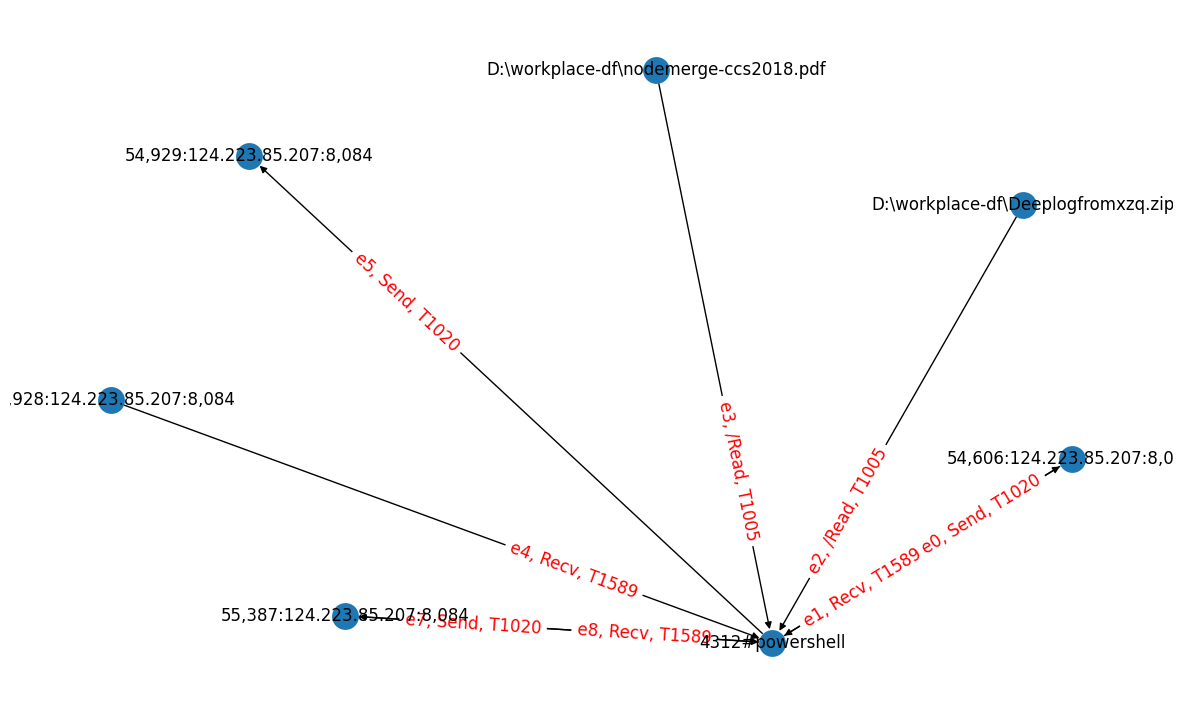

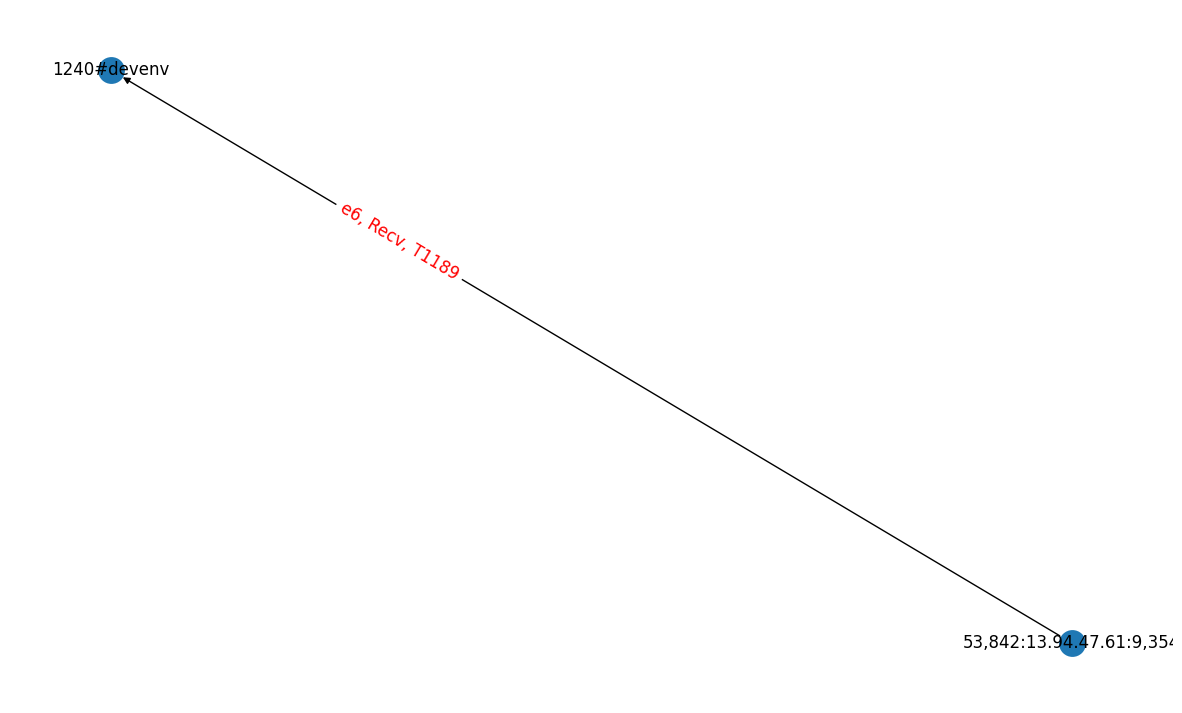

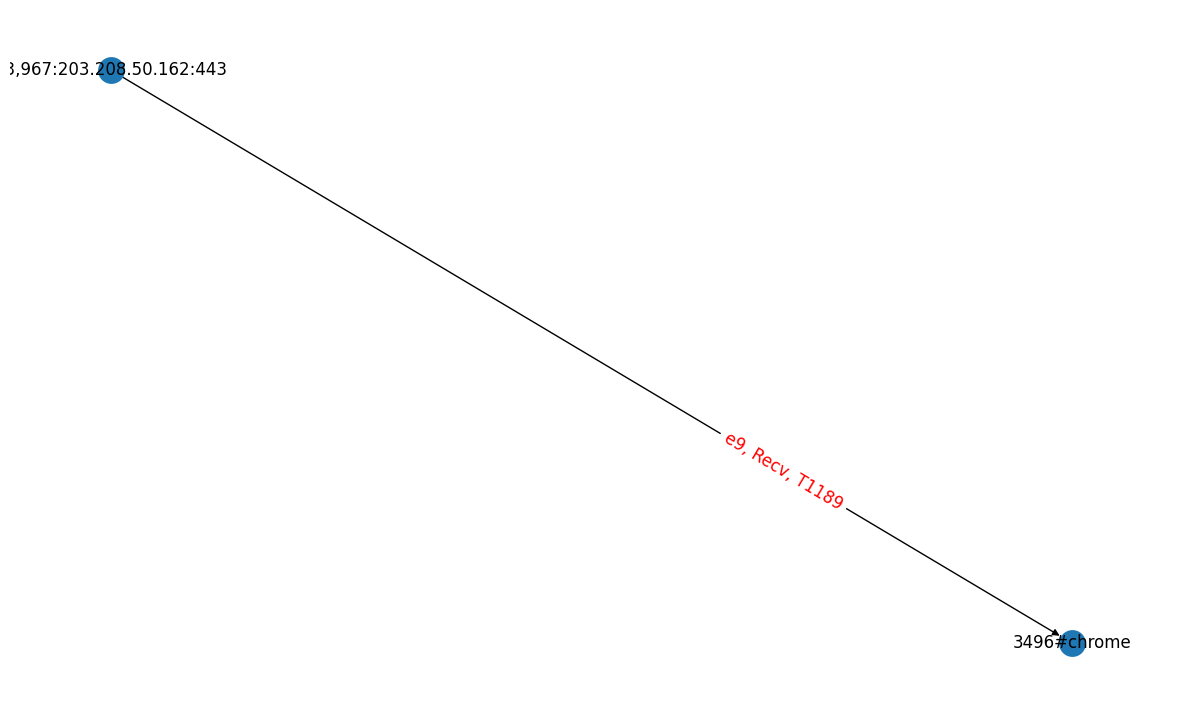

In [30]:
seq_ind = 11
data_for_sequence = test_data_for_model['data_for_sequences'][seq_ind]
seq_to_explain, labels = data_for_sequence['logs_for_sequence'], data_for_sequence['next_event_types']

#generate graph for the sequence
# sorted_components, edge_to_event_ind, node_label_dict, edge_label_dict = data_handler.generate_graph_for_sequence(seq_ind)
graph_data_for_seq = test_data_for_graph["data_for_sequences"][seq_ind]
node2label_dict = test_data_for_graph['node2label_dict']
cur_nodes_ls = graph_data_for_seq['nodes_ls']
cur_edges_ls = graph_data_for_seq['edges_ls']

g = nx.MultiDiGraph()  # Creating Directed Graph #MultiDiGraph
# adding nodes and vertices
g.add_nodes_from(cur_nodes_ls)
g.add_edges_from(cur_edges_ls)
sorted_components = sorted([g.subgraph(subg) for subg in nx.weakly_connected_components(g)], key=len, reverse=True)

for ind, subg in enumerate(sorted_components):
    fig, ax = plt.subplots(figsize=(15,9))

    pos = nx.spring_layout(subg, k=2000, iterations=2000) 

    nx.draw_networkx_nodes(
          subg, pos,
          linewidths=2,

      )


    nx.draw_networkx_labels(
          subg, pos,
          labels={node_id:node2label_dict[node_id] for node_id in subg.nodes()},
      )

    new_pos = nx.draw_networkx_edges(
          subg, pos,
          label={x:graph_data_for_seq['edge2label_dict'][x] for x in subg.edges()},
          min_source_margin = 10,
          min_target_margin = 10,
          arrows = True, 
      )

    n =  nx.draw_networkx_edge_labels(
          subg, pos,
          edge_labels={x:graph_data_for_seq['edge2label_dict'][x] for x in subg.edges()} ,
          font_color='red',
          font_size=12,
          label_pos=0.3,
          )

    plt.axis('off')

## CyberShplay phase 2: Calculate importance of the informative features

In [31]:
graph_ls = []
for ind, subgraph in enumerate(sorted_components):
    subgraph_edges = list(subgraph.edges())
    events_of_subgraph = [graph_data_for_seq['edge2info_dict'][x][0] for x in subgraph_edges]
    flattened_subgraph_events_list = set([e for e_list in events_of_subgraph for e in e_list])
    graph_ls.append(flattened_subgraph_events_list)

explain_latent_space = True
num_varying_features = len(graph_ls)
combination_samples = sample_all_combinations(sequence=seq_to_explain,
                                                           graph_ls=graph_ls,
                                                           num_connected_comp=num_varying_features,
                                                  explain_subgraphs=explain_latent_space)


pred_coal = predict_prob_to_coalitions(combination_samples, model, labels)


base_val = 0
pred_for_coalition = pred_coal[:-1,1]
pred_for_sample = pred_coal[-1,1]
high_level_coals = combination_samples[:-1,0]
maskMatrix = np.array([[1 if ind in coal else 0 for ind in range(num_varying_features)] for coal in high_level_coals])
kernelWeights = combination_samples[:-1, 2].astype(float)
shapley_vals = shapley_values_with_weighted_linear_reg(ey=pred_for_coalition, fnull=base_val, fx=pred_for_sample, maskMatrix=maskMatrix, kernelWeights=kernelWeights, features_num=num_varying_features)

: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [32]:
num_varying_features

3

In [33]:
shapley_vals

array([0.75962867, 0.00915487, 0.11972949])

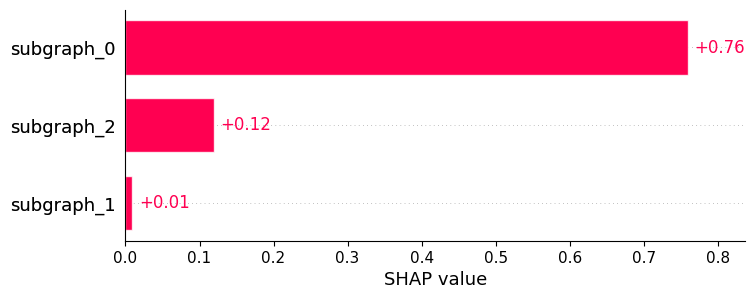

In [34]:
feature_names = [f"subgraph_{i}" for i in range(len(shapley_vals))]
explanation_object = Explanation(values=shapley_vals,
                            base_values=base_val,
                            feature_names = feature_names)
shap.plots.bar(explanation_object, show=False)

# CyberShplay output:
Combine the feature importance with the informative graphs: 

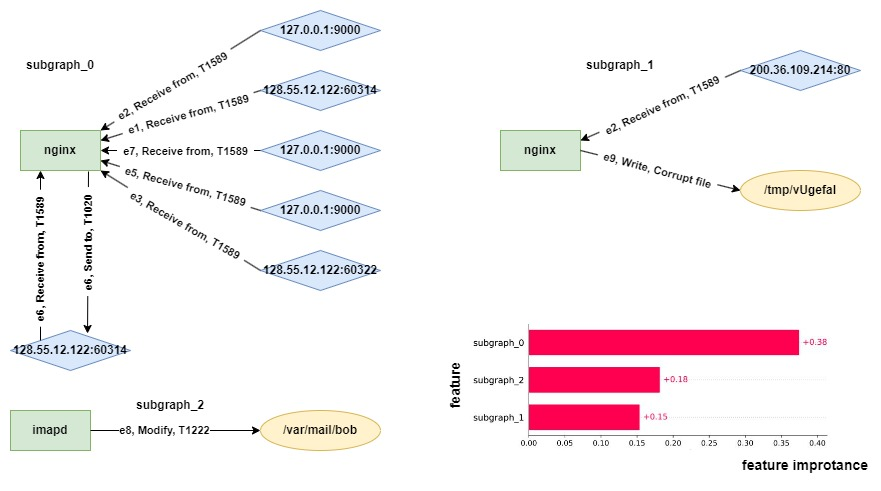